# Electromiografía: Binarización de la señal. 
### Flores Oliva Alejandro Elliot
#### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

## Índice:

[1. Configuración/Diseño del notebook. ](#1)

[2. Extraer y graficar los datos. ](#2)

[3. Cambios en la amplitud de la señal EMG .](#3)

[4. Calcular la amplitud máxima en cada bin.](#4)

[5. Calculo de la amplitud media de los bins.](#5)

[6. Calculo de la varianza en la amplitud para cada bin. ](#6)

[7. Cambios en la frecuencia EMG. ](#7)

[8. Cambios en la densidad espectral de potencia (PSD). ](#8)

[9. Frecuencias de potencia media y mediana. ](#9)

La binarización de una señal de electromiografía (EMG) implica convertir la señal analógica continua en una señal digital binaria. La binarización se utiliza comúnmente para detectar la presencia o ausencia de actividad muscular, en nuestro estudio es importante para detectar actvidad espontánea cuando no hay contracción alguna.

<a id='1'></a>
## Configuración/Diseño del notebook.

#### Librerías utilizadas
Importamos los módulos de Python para trazar figuras, gráficos en el cuaderno y crear figuras con buena resolución y etiquetas grandes.
Importamos las librerías/ módulos que nos permitirán hacer cálculos, filtrar datos, utilizar filtros, análisis, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import math
from scipy.signal import filtfilt, butter

<a id='2'></a>
## Extraer y graficar los datos.

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio [.wav]. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

In [2]:
def processEMG(file, graph):
    # Abrimos el archivo .wav especificando la ruta y el nombre del archivo
    record = wave.open(file)
    
    # Extrae el número de canales, frecuencia de muestreo y datos
    numChannels = record.getnchannels()        # Número de canales
    N = record.getnframes()                    # Número de fotogramas
    sampleRate = record.getframerate()         # Tasa de muestreo
    
    # Extraer datos del archivo .wav
    dstr = record.readframes(N * numChannels)
    waveData = np.frombuffer(dstr, np.int16)
    
    # Dividir datos en dos canales
    channel1 = waveData[::numChannels]
    channel2 = waveData[1::numChannels]
    
    # Calcular ventana de tiempo
    timeEMG = np.linspace(0, len(channel1) / sampleRate, num=len(channel1))
    
    # Calcular frecuencia
    freq = 1 / np.mean(np.diff(timeEMG))
    
    # Filtro Band-pass Butterworth de 10-400Hz
    b, a = butter(2, ([10, 400] / (freq / 2)), btype='bandpass')
    filtered1 = filtfilt(b, a, channel1)
    filtered2 = filtfilt(b, a, channel2)
    
    # Rectificar la señal EMG filtrada
    absSignal1 = np.absolute(filtered1)
    absSignal2 = np.absolute(filtered2)
    
    # Calcular tiempo para señales absolutas
    timeAbs = np.linspace(0, len(absSignal1) / sampleRate, num=len(absSignal1))
    
    # Filtro Butterworth de paso bajo para detección de envolvente
    lowp = 8
    sfreq = sampleRate
    low_pass = lowp / sfreq
    b, a = butter(4, low_pass, btype='lowpass')
    env1 = filtfilt(b, a, absSignal1)
    env2 = filtfilt(b, a, absSignal2)
    
    # Guardar datos relevantes en un diccionario
    xx = {
        'sampleRate': sampleRate,
        'waveData':waveData,
        'channel1': channel1,
        'channel2': channel2,
        'timeEMG': timeEMG,
        'freq': freq,
        'filtered1': filtered1,
        'filtered2': filtered2,
        'absSignal1': absSignal1,
        'absSignal2': absSignal2,
        'timeAbs': timeAbs,
        'env1': env1,
        'env2': env2
    }
    
    # Graficamos EMG 
    if graph:
        fig, (ax1, ax2, ax3, ax4, ax5, ax6 ,ax7 , ax8) = plt.subplots(8, 1, figsize=(50, 40))
        
        # Trazar datos canal 1
        ax1.plot(timeEMG, channel1, 'b', label='Channel 1')
        ax1.set_title('Señal sin filtro de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 1 (derecho)', fontsize=20)
        ax1.set_xlim(0, max(timeEMG))
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('Voltaje ($\mu$V)')
        ax1.legend(loc='upper right')
        
        # Trazar datos canal 2
        ax2.plot(timeEMG, channel2, 'r', label='Channel 2')
        ax2.set_title('Señal sin filtro de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 2 (izquierdo)', fontsize=20)
        ax2.set_xlim(0, max(timeEMG))
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Voltaje ($\mu$V)')
        ax2.legend(loc='upper right')
        
        # Trazar datos filtrados canal 1
        ax3.plot(timeEMG, filtered1, 'b', label='Channel 1')
        ax3.set_title('Señal filtrada de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 1 (derecho)', fontsize=20)
        ax3.set_xlim(0, max(timeEMG))
        ax3.set_xlabel('Tiempo (s)')
        ax3.set_ylabel('Voltaje ($\mu$V)')
        ax3.legend(loc='upper right')
        
        # Trazar datos filtrados canal 2
        ax4.plot(timeEMG, filtered2, 'r', label='Channel 2')
        ax4.set_title('Señal filtrada de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 2 (izquierdo)', fontsize=20)
        ax4.set_xlim(0, max(timeEMG))
        ax4.set_xlabel('Tiempo (s)')
        ax4.set_ylabel('Voltaje ($\mu$V)')
        ax4.legend(loc='upper right')
        
        # Trazar datos rectificados con envolvente canal 1
        ax5.plot(timeAbs, env1 * 3, 'b', label='Channel 1')
        ax5.plot(timeAbs, absSignal1, 'gray', alpha=0.4)
        ax5.set_title('EMG rectificado con envolvente de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 1 (derecho)', fontsize=20)
        ax5.set_xlim(0, max(timeEMG))
        ax5.set_xlabel('Tiempo (s)')
        ax5.set_ylabel('Voltaje ($\mu$V)')
        ax5.legend(loc='upper right')
        
        # Trazar datos rectificados con envolvente canal 2
        ax6.plot(timeAbs, env2 * 3, 'r', label='Channel 2')
        ax6.plot(timeAbs, absSignal2, 'gray', alpha=0.4)
        ax6.set_title('EMG rectificado con envolvente de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 2 (izquierdo)', fontsize=20)
        ax6.set_xlim(0, max(timeEMG))
        ax6.set_xlabel('Tiempo (s)')
        ax6.set_ylabel('Voltaje ($\mu$V)')
        ax6.legend(loc='upper right')

        # Trazar envolvente con umbral potencial canal 1
        ax7.plot(timeAbs, env1, 'b', label='Channel 1')
        ax7.set_title('EMG envoltura de los músculos del extensor radial del carpo largo en relajación con medicamento- canal 1 (derecho)', fontsize=20)
        ax7.set_xlim(0, max(timeEMG))
        ax7.set_xlabel('Tiempo (s)')
        ax7.set_ylabel('Voltaje ($\mu$V)')
        ax7.legend(loc='upper right')
        
        # Trazar envolvente con umbral potencial canal 2
        ax8.plot(timeAbs, env2, 'r', label='Channel 2')
        ax8.set_title('EMG envoltura de los músculos del extensor radial del carpo largo en relajación sin medicamento- canal 2 (izquierdo)', fontsize=20)
        ax8.set_xlim(0, max(timeEMG))
        ax8.set_xlabel('Tiempo (s)')
        ax8.set_ylabel('Voltaje ($\mu$V)')
        ax8.legend(loc='upper right')
        
        
        # Espaciado entre subparcelas
        plt.tight_layout(pad=3.0)
    
    return xx

<a id='3'></a>
## Cambios en la amplitud de la señal EMG 

Los músculos se caracterizan por tener actividad en forma de contracciones cada vez que hacen un ejercicio controlado o movimiento, aunque después de una actividad prolongada se fatigan, muchas actividades ameritan un esfuerzo significativo, en este apartado estudiaremos las diversas formas de visualizar y cuantificar la amplitud/fatiga.

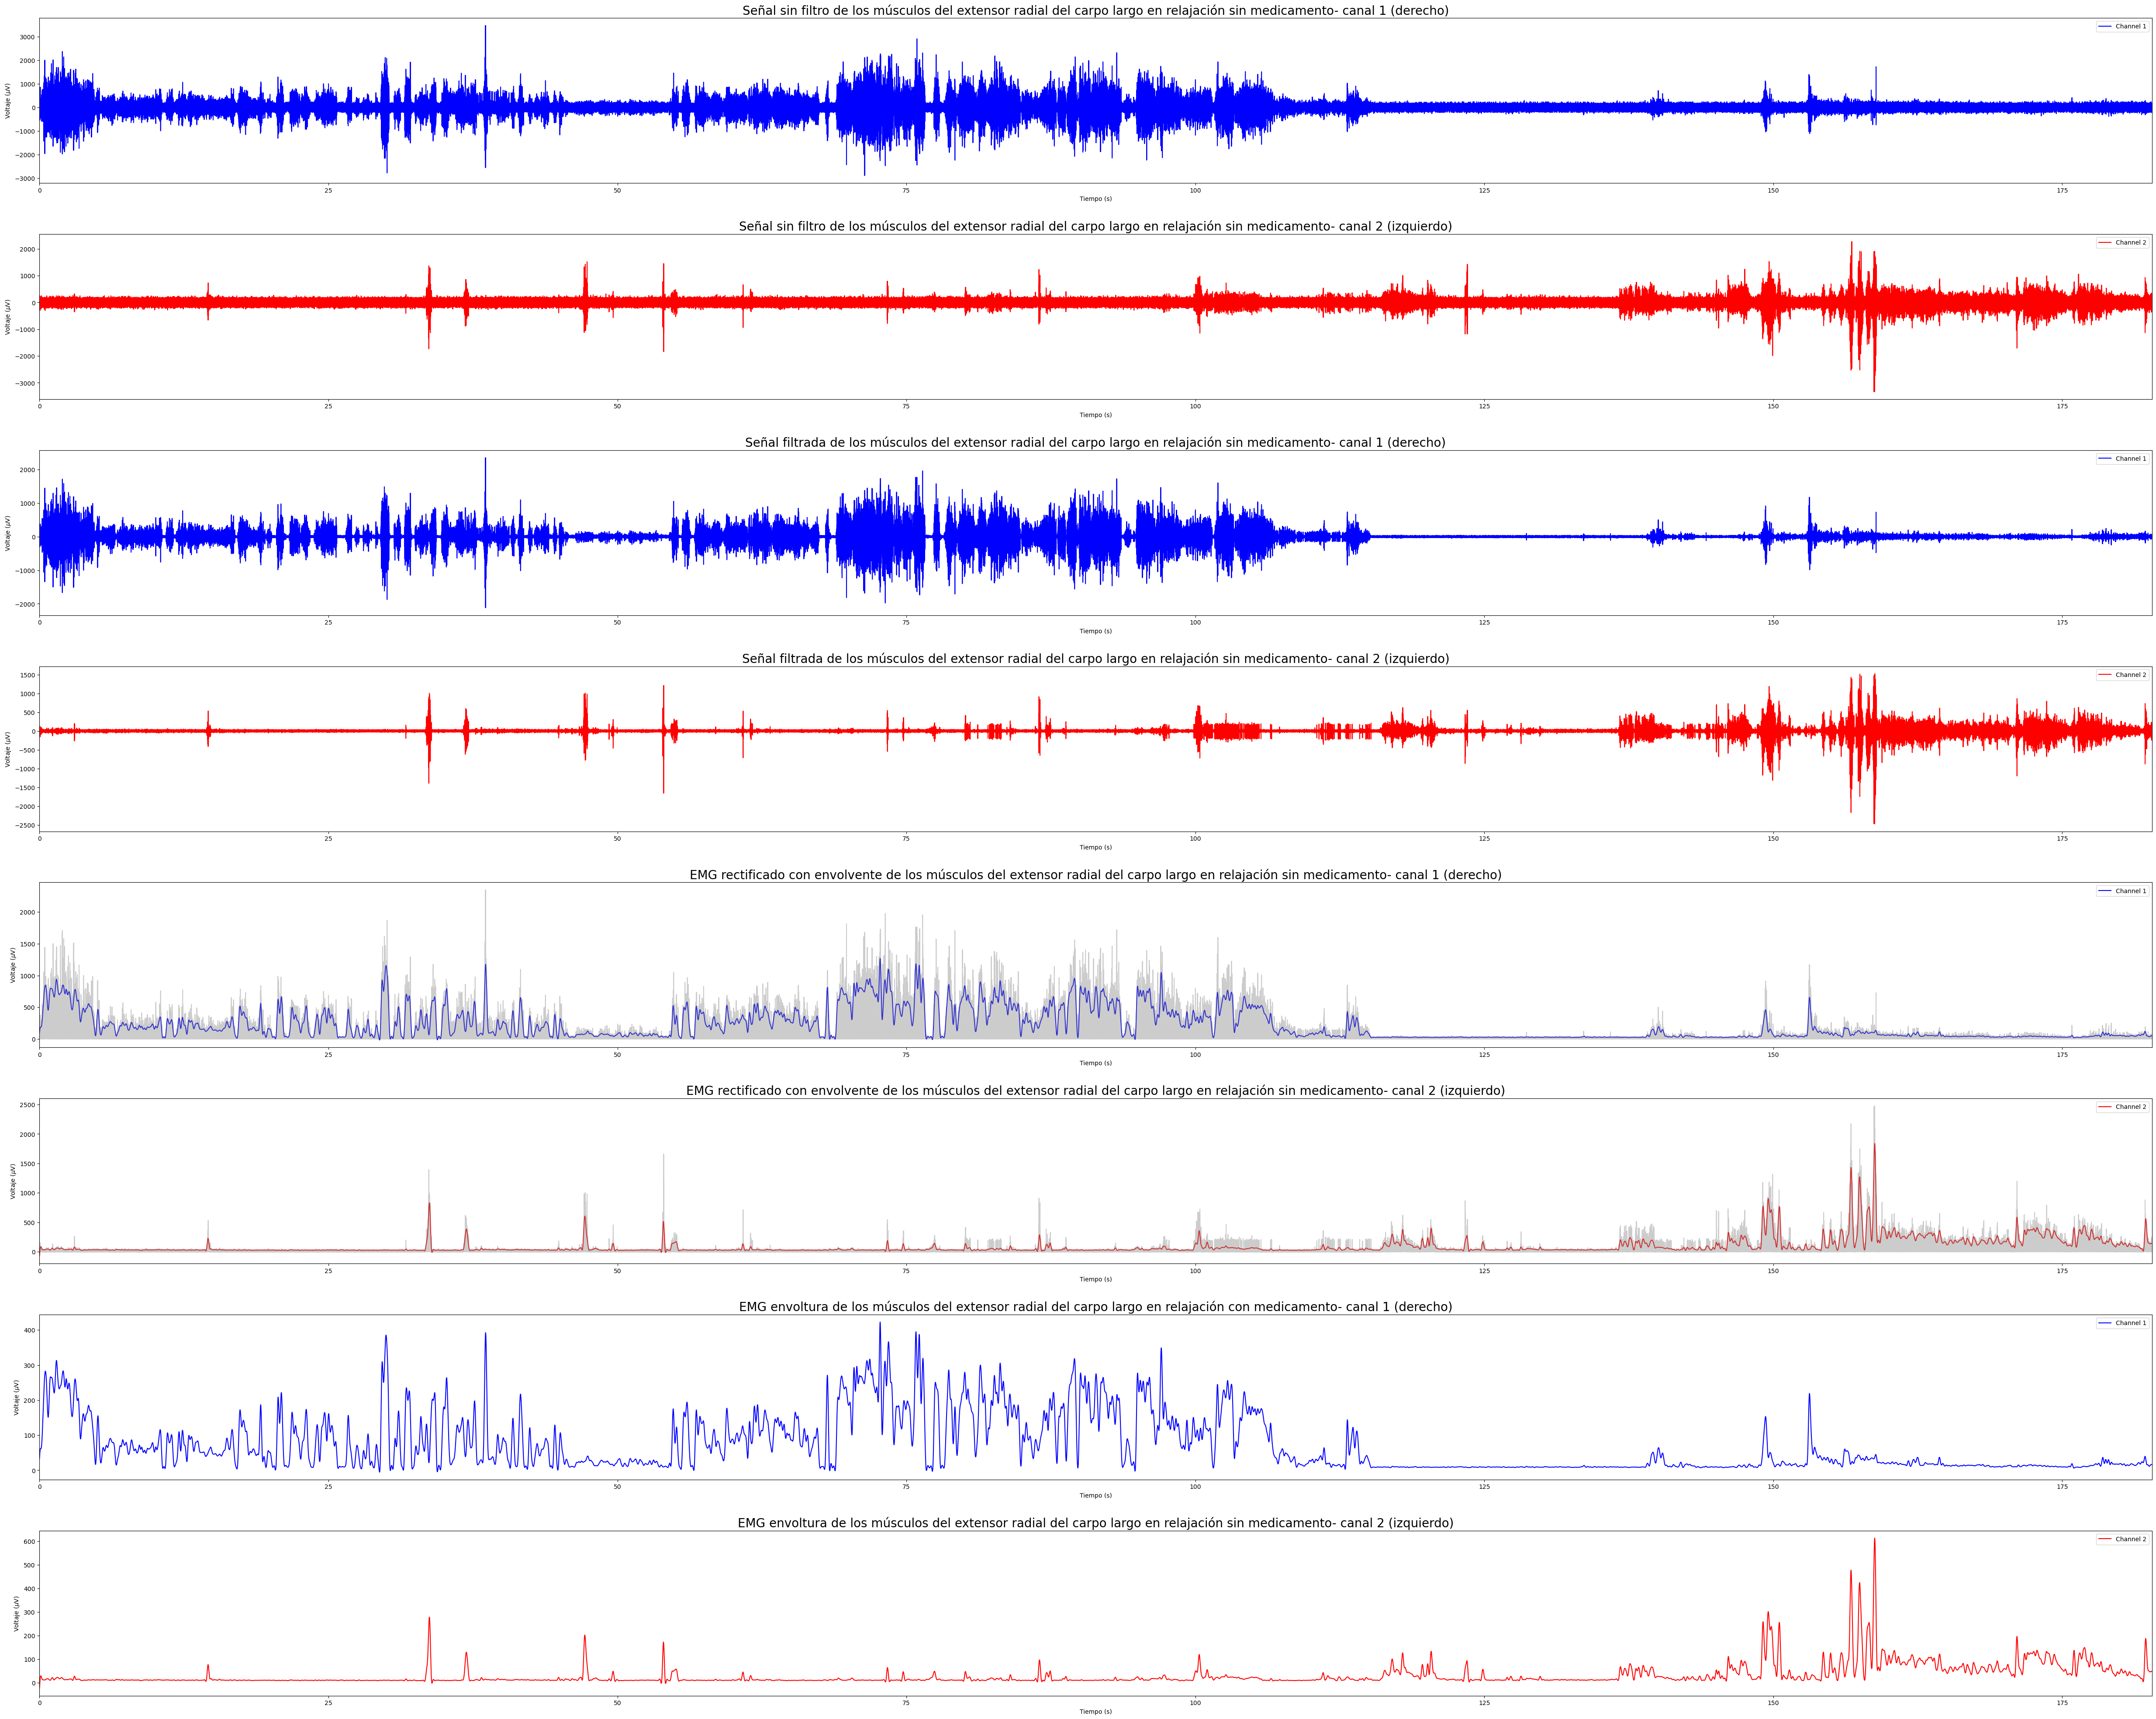

In [3]:
# Abra el archivo de señal y trace los datos
xx = processEMG(file='../Parkinson Notebooks/1-Registros-EMG/Sin medicamento/SM_Registro_FlexorLargo_Relajación.wav', graph=True)

<a id='4'></a>
## Calcular la amplitud máxima en cada bin

Calcular la amplitud máxima en cada bin de una señal permite el análisis de señales, puede ser útil debido:

> **Detección de Eventos:** Permite encontrar cambios significativos en una señal. Al calcular la amplitud máxima en cada bin, puedes determinar los segmentos donde la señal alcanza valores destacados.

> **Análisis de Señales :** Al calcular la amplitud máxima en cada bin de una señal, podemos obtener información sobre los valores más altos (picos) en segmentos discretos de la señal.

> **Segmentación de la señal:** En algunas tareas de clasificación de señales, la amplitud máxima en cada bin se utiliza para segmentar la señal en partes significativas o para dividir la señal en segmentos más manejables.

> **Detección de artefactos:**  Calcular la amplitud máxima en cada bin puede ser útil para detectar picos de ruido experimental lo que permitirá descartar ciertos estímulos.

> **Compresión de Datos:** En algunas técnicas de compresión de datos, se pueden utilizar valores máximos en cada bin para reducir la cantidad de información necesaria para representar una señal. 

En general, el cálculo de la amplitud máxima en cada bin proporciona información sobre la distribución de valores en diferentes partes de una señal.

Como podemos ver en la grabación anterior, la amplitud de la señal cambia a medida que avanza la grabación y el músculo presumiblemente tiene actividad espontánea sin necesidad de realizar una contracción. Una forma de cuantificar esto es agrupar los datos y encontrar la amplitud máxima de la señal dentro de cada intervalo. Para mayor facilidad, primero dividimos los datos en bins de 1 segundo.

Posteriormente, iteramos sobre los bins, calculamos la amplitud máxima para cada bin y graficamos los resultados.

La grabación tiene 365 bins de 1 segundo de duración.


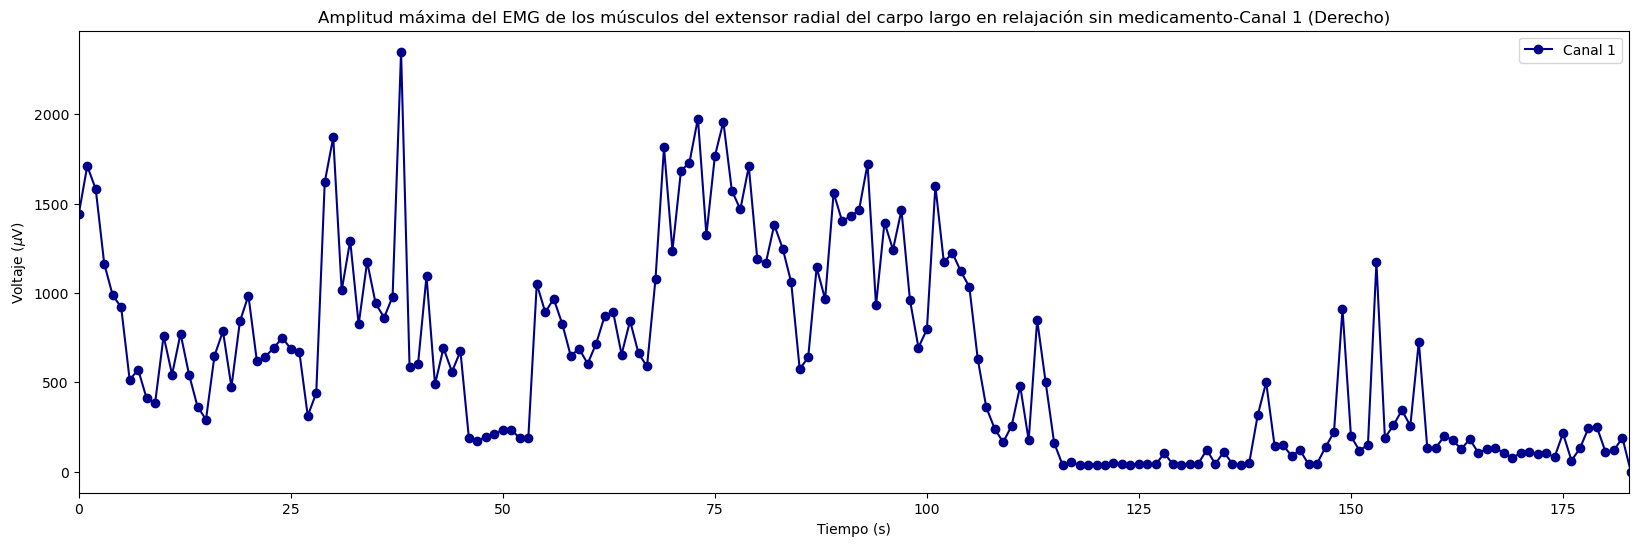

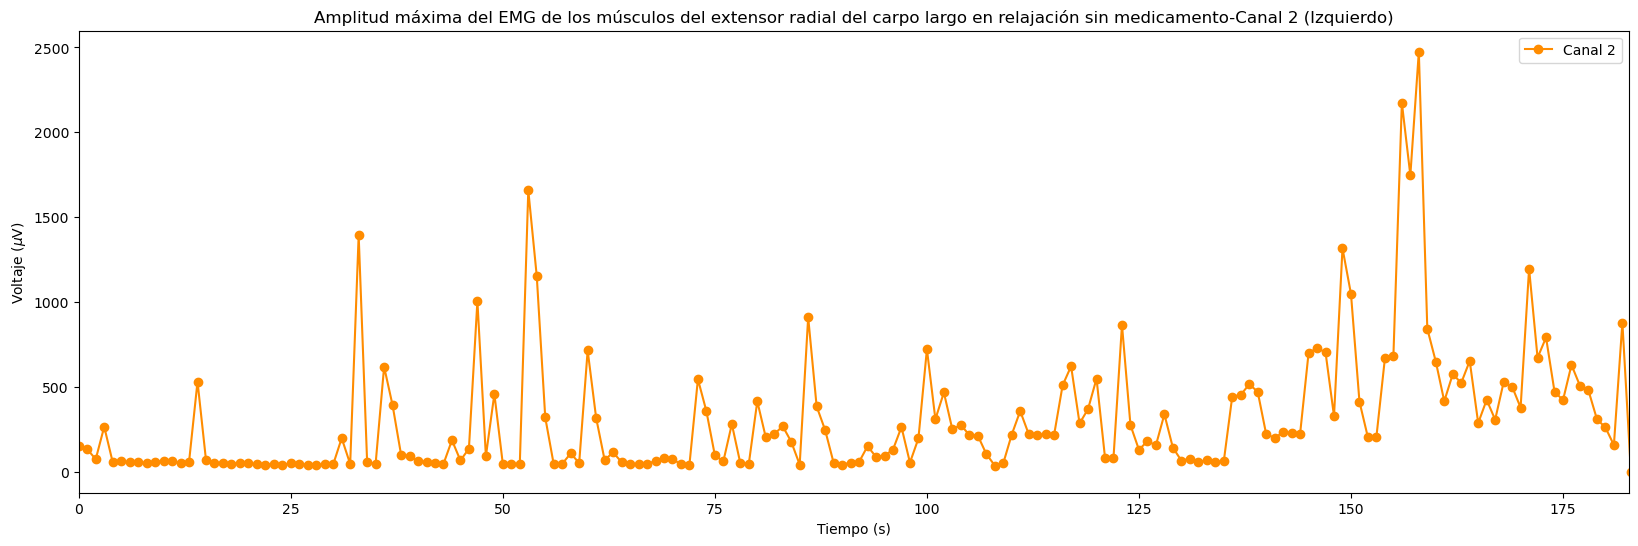

In [4]:
# Calcular el número de bins de 1 segundo
nbins = math.floor(len(xx['waveData'])/xx['sampleRate'])
print('La grabación tiene %d bins de 1 segundo de duración.' % nbins)
    
# Función para crear bins
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width + 1, width):
        bins.append((low, low + width))
    return bins
    
# Crear los bins
secBins = createBins(0,xx['sampleRate'],nbins)
    
# calcular la amplitud máxima sobre los bins
x = secBins
y1 = xx['absSignal1']
y2 = xx['absSignal2']

# Calcular la amplitud máxima en cada bin
maxamps_channel1 = []
maxamps_channel2 = []

for n in range(0, len(x)):
    if len(y1[min(x[n]):max(x[n])]) > 0:
        max_amp_channel1 = y1[min(x[n]):max(x[n])].max()
    else:
        max_amp_channel1 = 0

    if len(y2[min(x[n]):max(x[n])]) > 0:
        max_amp_channel2 = y2[min(x[n]):max(x[n])].max()
    else:
        max_amp_channel2 = 0

    maxamps_channel1.append(max_amp_channel1)
    maxamps_channel2.append(max_amp_channel2)
    
# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(maxamps_channel1, 'o-', color='darkblue', label='Canal 1')
plt.title('Amplitud máxima del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 1 (Derecho)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0,max(xx['timeEMG']));
plt.legend()
plt.show()
    
# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(maxamps_channel2, 'o-', color='darkorange', label='Canal 2')
plt.title('Amplitud máxima del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 2 (Izquierdo)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0,max(xx['timeEMG']));
plt.legend()
plt.show()

<a id='5'></a>
## Calculo de la amplitud media de los bins

El calculo de la amplitud media de los bins en una señal permite el análisis y procesamiento de señales. Al obtener la amplitud media en cada bin, se obtiene información sobre los valores promedio en segmentos discretos de la señal o imagen. Puede ser útil para obtener:

> **Caracterización de Señales:** Al calcular la amplitud media en cada bin, brinda información sobre los valores promedio en diferentes segmentos de la señal. Esto puede ayudar a caracterizar la distribución de amplitudes en la señal y proporcionar comportamiento de la señal.

> **Detección de Tendencias o Niveles Basales:** Algunas señales pueden contener ruido o fluctuaciones, calcular la amplitud media en cada bin puede ayudar a detectar tendencias o niveles basales. 

> **Comparación de Señales:** Calcular la amplitud media de los bins en múltiples señales puede ayudar a comparar sus características generales, puede ser útil para comparar la actividad muscular en ciertas condiciones.

> **Segmentación de la señal:** Al igual que con la amplitud máxima, la amplitud media en cada bin también puede usarse como una característica para la segmentación de señales, puede ser útil para identificar patrones o clasificar diferentes tipos de señales.

> **Compresión de Datos:** Al igual que con la amplitud máxima, la amplitud media en cada bin también se pueden utilizar valores máximos en cada bin para reducir la cantidad de información necesaria para representar una señal.


En general, calcular la amplitud media de los bins en una señal brinda información sobre los valores promedio en segmentos discretos al realizar este análisis, permite la comparación de señales.

En cambio, también podemos iterar sobre los bins y calcular la amplitud media para ver si eso nos da una imagen más clara de la disminución debido a la fatiga.

La grabación tiene 365 bins de 1 segundo de duración.


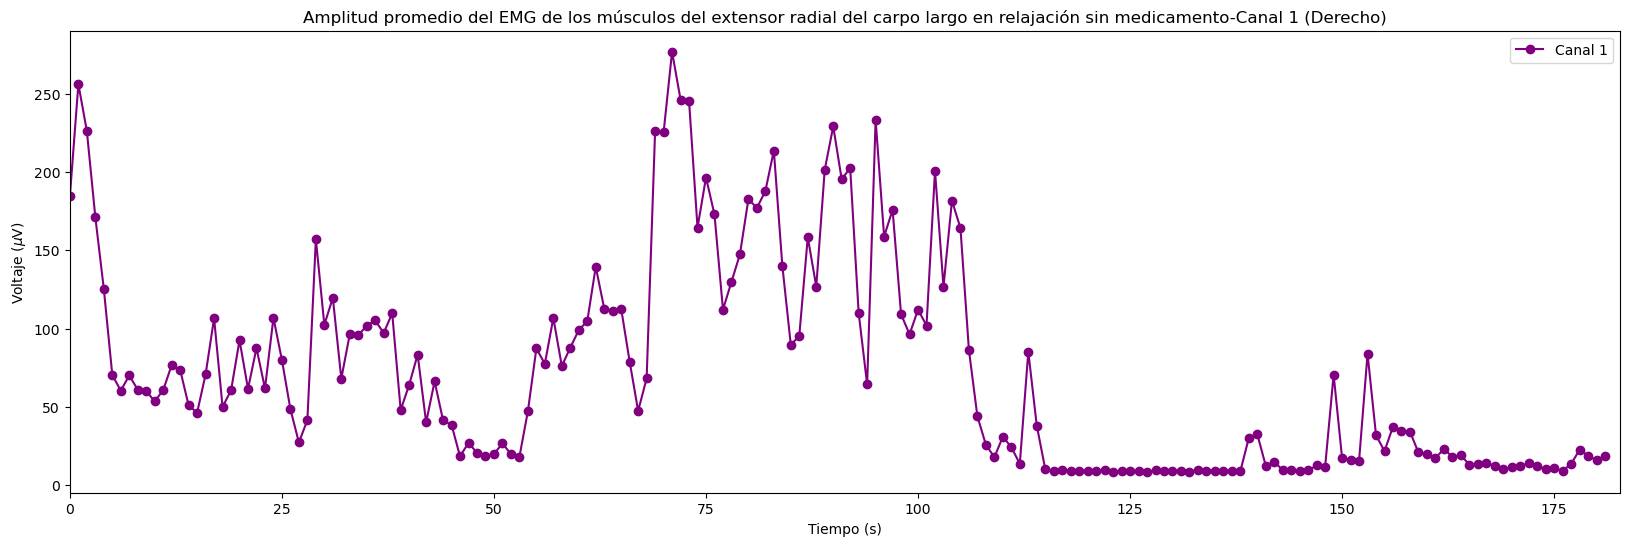

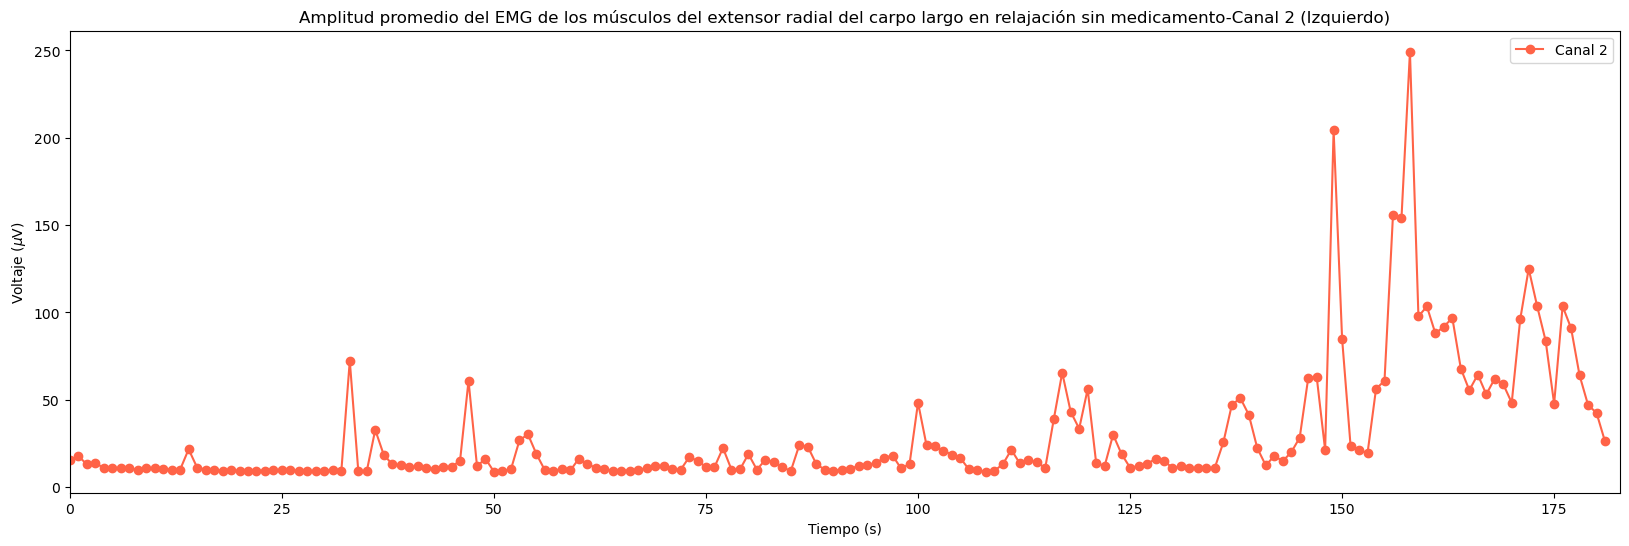

In [6]:
# Calcular el número de bins de 1 segundo
nbins = math.floor(len(xx['waveData']) / xx['sampleRate'])
print('La grabación tiene %d bins de 1 segundo de duración.' % nbins)

# Función para crear bins
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width + 1, width):
        bins.append((low, low + width))
    return bins

# Crear los bins
secBins = createBins(0, xx['sampleRate'], nbins)

# calcular la amplitud máxima sobre los bins
x = secBins
y1 = xx['absSignal1']
y2 = xx['absSignal2']

# Calcular la amplitud promedio en cada bin para cada canal
meanamps_channel1 = []
meanamps_channel2 = []

for n in range(len(x)):
    lower_index = min(x[n])
    upper_index = max(x[n])

    if lower_index < len(y1) and upper_index < len(y1) and lower_index < upper_index:
        mean_amp_channel1 = np.nanmean(y1[lower_index:upper_index])
    else:
        mean_amp_channel1 = np.nan
    
    if lower_index < len(y2) and upper_index < len(y2) and lower_index < upper_index:
        mean_amp_channel2 = np.nanmean(y2[lower_index:upper_index])
    else:
        mean_amp_channel2 = np.nan
    
    meanamps_channel1.append(mean_amp_channel1)
    meanamps_channel2.append(mean_amp_channel2)

# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(meanamps_channel1, 'o-', color='purple', label='Canal 1')
plt.title('Amplitud promedio del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 1 (Derecho)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0, max(xx['timeEMG']))
plt.legend()
plt.show()

# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(meanamps_channel2, 'o-', color='tomato', label='Canal 2')
plt.title('Amplitud promedio del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 2 (Izquierdo)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0, max(xx['timeEMG']))
plt.legend()
plt.show()


<a id='6'></a>
## Calcular la varianza en la amplitud para cada bin

Calcular la varianza en la amplitud para cada bin de una señal, permita estudiar la dispersión la cual indica qué tan dispersos están los valores alrededor de su media. Para calcular la varianza en la amplitud de cada bin, primeramente necesitas tener los datos de amplitud en cada bin.

También podemos calcular la varianza sobre los bins, lo que también puede indicar fatiga o cambios anormales de amplitud debido a actividad espontánea.

La grabación tiene 365 bins de 1 segundo de duración.


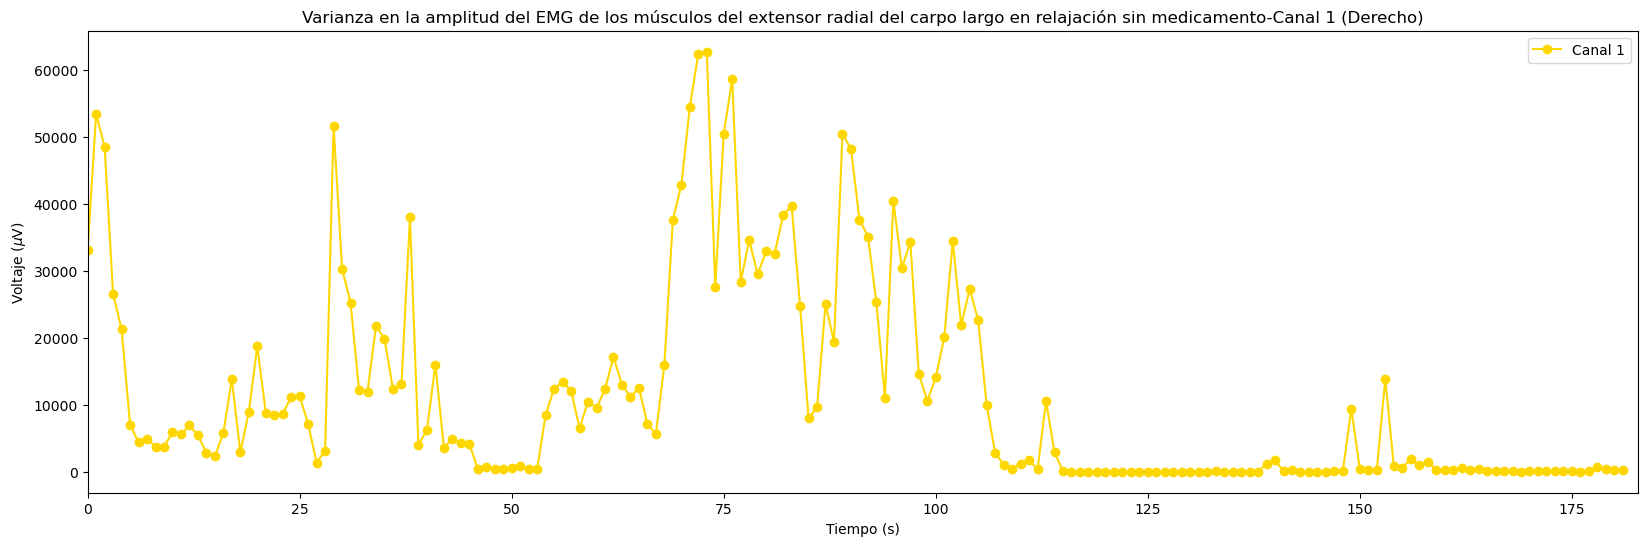

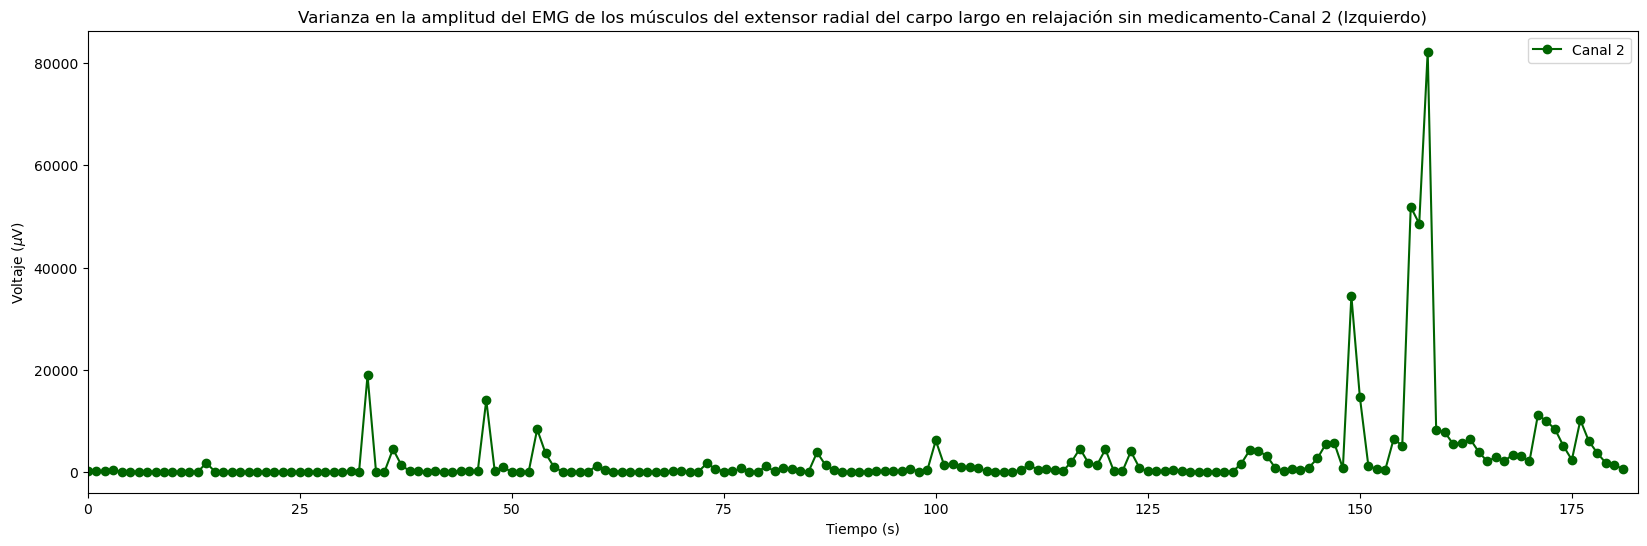

In [7]:
# Calcular el número de bins de 1 segundo
nbins = math.floor(len(xx['waveData']) / xx['sampleRate'])
print('La grabación tiene %d bins de 1 segundo de duración.' % nbins)

# Función para crear los bins
def createBins(lower_bound, width, quantity):
    bins = []
    for low in range(lower_bound, lower_bound + quantity * width, width):
        bins.append((low, low + width))
    return bins

# Crear los bins de 1 segundo
secBins = createBins(0, xx['sampleRate'], nbins)

# calcular la amplitud máxima sobre los bins
x = secBins
y1 = xx['absSignal1']
y2 = xx['absSignal2']

# Calcular la varianza en la amplitud para cada bin para cada canal
varamps_channel1 = []
varamps_channel2 = []

for bin_start, bin_end in secBins:
    # Verificar si hay suficientes elementos en la "rebanada" para calcular la varianza
    if bin_end <= len(y1):
        var_amp_channel1 = np.var(y1[bin_start:bin_end])
    else:
        var_amp_channel1 = np.nan
    
    if bin_end <= len(y2):
        var_amp_channel2 = np.var(y2[bin_start:bin_end])
    else:
        var_amp_channel2 = np.nan

    varamps_channel1.append(var_amp_channel1)
    varamps_channel2.append(var_amp_channel2)

# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(varamps_channel1, 'o-', color='gold', label='Canal 1')
plt.title('Varianza en la amplitud del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 1 (Derecho)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0, max(xx['timeEMG']))
plt.legend()
plt.show()

# Graficar los resultados
plt.figure(figsize=(20, 6))
plt.plot(varamps_channel2, 'o-', color='darkgreen', label='Canal 2')
plt.title('Varianza en la amplitud del EMG de los músculos del extensor radial del carpo largo en relajación sin medicamento-Canal 2 (Izquierdo)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlim(0, max(xx['timeEMG']))
plt.legend()
plt.show()


<a id='7'></a>
## Cambios en la frecuencia EMG



Podemos observar:
>La fatiga muscular también está marcada por una disminución en la frecuencia de la señal EMG, que puede resultar tanto de una disminución en la velocidad de disparo de las unidades motoras individuales como de una disminución en el número total de unidades motoras activas.

>Actividad espontánea debido a la Enfermedad de Parkinson.

Se elaboró un código que nos permita observar y calcular la morfología de la señal:

+ Dividimos los datos de EMG en ventanas que ejecutaremos a través del análisis de frecuencia.

+ Calculamos la densidad espectral de potencia (PSD) usando una transformada de Fourier.

>> En general, calcular la Densidad Espectral de Potencia (PSD) utilizando una Transformada de Fourier es una herramienta fundamental en el análisis de señales, proporciona información esencial sobre el contenido de frecuencia de una señal. La PSD es una herramienta que permite detección de eventos y tambien es valiosa para analizar el nivel de ruido en una señal,

+ Trazamos los resultados, mostrando la señal EMG en el primer bin (bin 0), la PSD para esos bins y el logaritmo de la PSD.

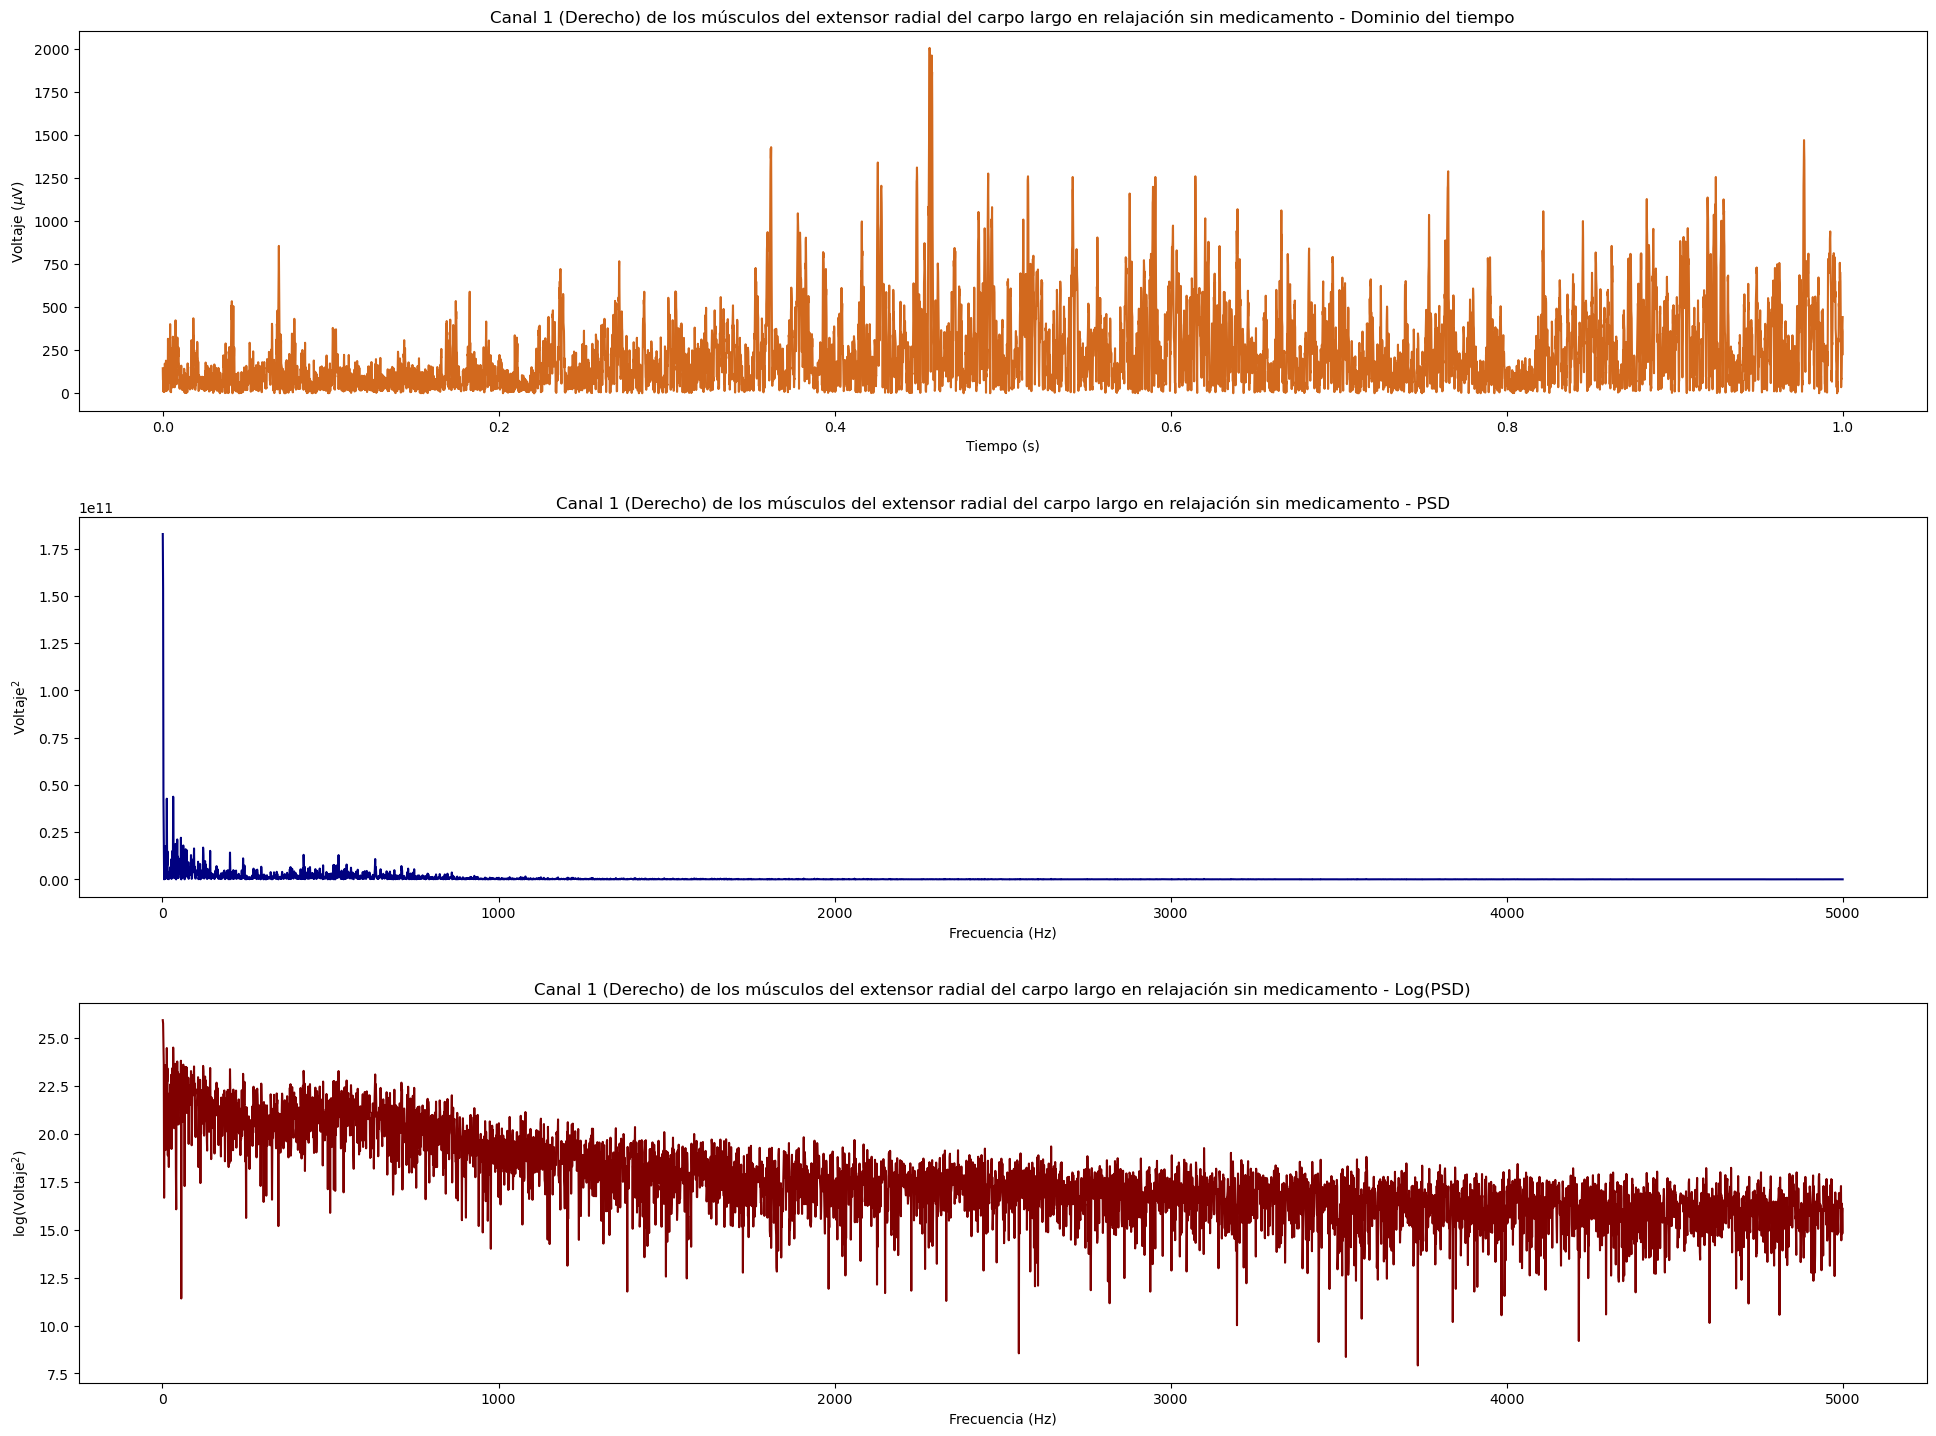

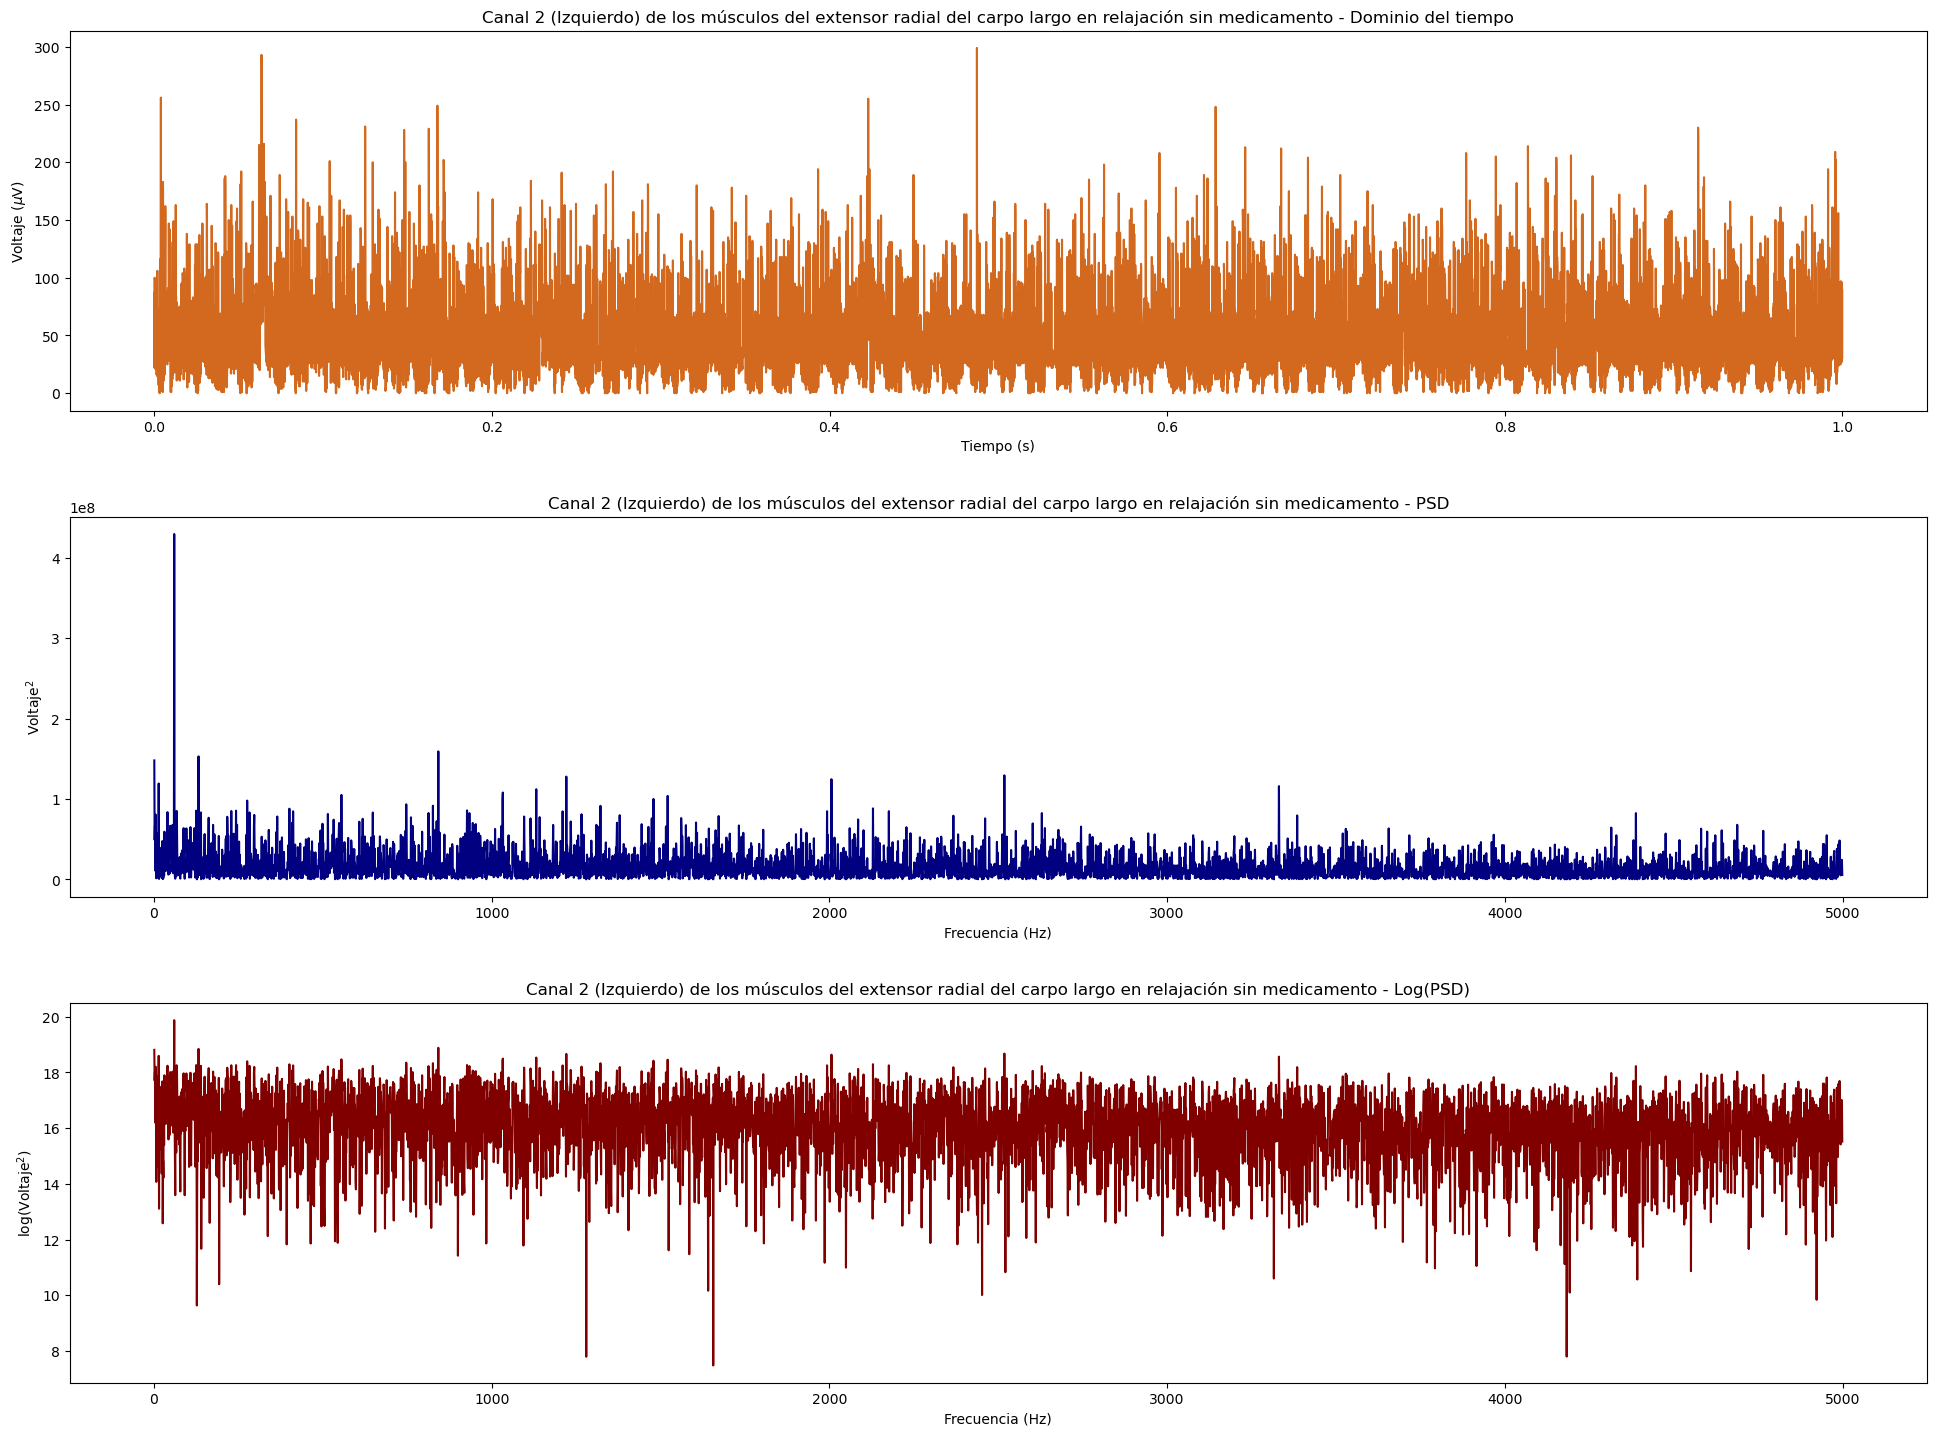

In [8]:
# Ruta del archivo .wav
file_path = '../Parkinson Notebooks/1-Registros-EMG/Sin medicamento/SM_Registro_FlexorLargo_Relajación.wav'

# Definir la función para dividir la señal en ventanas
def windows(data, npoints, step):
    datapts = np.size(data)
    anchorpts = np.arange(0, datapts - npoints, step)
    noverlap = len(anchorpts)
    ovData = [data[anchorpts[i]:anchorpts[i]+npoints] for i in range(noverlap)]
    return ovData

# Definir la función para calcular la PSD
def PSD(data, sampleRate):
    ps = np.abs(np.fft.fft(data))**2
    time_step = 1 / sampleRate
    freqs = np.fft.fftfreq(data.size, time_step)
    idx = np.argsort(freqs)
    good_inds = np.where(freqs[idx] > 0)[0]
    F = freqs[idx][good_inds]
    P = ps[idx][good_inds]
    return F, P

# Abrir el archivo .wav
with wave.open(file_path, 'rb') as wav_file:
    # Obtener los parámetros del archivo .wav
    num_channels = wav_file.getnchannels()
    sampleRate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    
    # Leer los datos de audio del archivo .wav
    audio_data = wav_file.readframes(num_frames)
    
    # Convertir los datos de audio a un arreglo numpy
    audio_data = np.frombuffer(audio_data, dtype=np.int16)
    
    # Asegurarse de que los valores sean absolutos positivos
    audio_data = np.abs(audio_data)
    
    # Si hay dos canales, separar los datos en dos arreglos
    if num_channels == 2:
        channel1 = audio_data[::2]  # Primer canal
        channel2 = audio_data[1::2]  # Segundo canal
    else:
        # Si no hay dos canales, duplicar los datos para tener dos canales
        channel1 = audio_data
        channel2 = audio_data
    
    # Definir los parámetros para las ventanas
    window_size = sampleRate
    window_step = sampleRate
    
    # Dividir la señal en ventanas para cada canal
    windowedEMG_channel1 = windows(channel1, window_size, window_step)
    windowedEMG_channel2 = windows(channel2, window_size, window_step)
    
    # Calcular la PSD para el primer canal
    F_channel1, P_channel1 = PSD(windowedEMG_channel1[0], sampleRate)
    
    # Graficar el primer canal
    fig = plt.figure(figsize=(20, 15))
    
    # Canal 1 - Señal en el dominio del tiempo
    ax = plt.subplot(311)
    plt.plot(np.arange(0,xx['sampleRate'])/xx['sampleRate'], windowedEMG_channel1[0], color='chocolate')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje ($\mu$V)')
    plt.title('Canal 1 (Derecho) de los músculos del extensor radial del carpo largo en relajación sin medicamento - Dominio del tiempo')
    
    # Canal 1 - PSD
    ax = plt.subplot(312)
    plt.plot(F_channel1, P_channel1, color='navy')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Voltaje$^2$')
    plt.title('Canal 1 (Derecho) de los músculos del extensor radial del carpo largo en relajación sin medicamento - PSD')
    
    # Canal 1 - Log PSD
    ax = plt.subplot(313)
    plt.plot(F_channel1, np.log(P_channel1), color='maroon')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('log(Voltaje$^2$)')
    plt.title('Canal 1 (Derecho) de los músculos del extensor radial del carpo largo en relajación sin medicamento - Log(PSD)')
    
    plt.tight_layout(pad=3.0)
    plt.show()

    
    # Calcular la PSD para el segundo canal
    F_channel2, P_channel2 = PSD(windowedEMG_channel2[0], sampleRate)
    
    # Graficar el segundo canal
    fig = plt.figure(figsize=(20, 15))
    
    # Canal 2 - Señal en el dominio del tiempo
    
    ax = plt.subplot(311)
    plt.plot(np.arange(0,xx['sampleRate'])/xx['sampleRate'], windowedEMG_channel2[0], color='chocolate')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje ($\mu$V)')
    plt.title('Canal 2 (Izquierdo) de los músculos del extensor radial del carpo largo en relajación sin medicamento - Dominio del tiempo')
    
    # Canal 2 - PSD
    ax = plt.subplot(312)
    plt.plot(F_channel2, P_channel2, color='navy')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Voltaje$^2$')
    plt.title('Canal 2 (Izquierdo) de los músculos del extensor radial del carpo largo en relajación sin medicamento - PSD')
    
    # Canal 2 - Log PSD
    ax = plt.subplot(313)
    plt.plot(F_channel2, np.log(P_channel2), color='maroon')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('log(Voltaje$^2$)')
    plt.title('Canal 2 (Izquierdo) de los músculos del extensor radial del carpo largo en relajación sin medicamento - Log(PSD)')
    
    plt.tight_layout(pad=3.0)
    plt.show()


<a id='8'></a>
## Cambios en la densidad espectral de potencia (PSD)

Comparar la primera ventana, la segunda ventana número 10 y la última ventana de un registro de EMG (Electromiografía) para observar cómo cambia la Densidad Espectral de Potencia (PSD) tiene varias aplicaciones importantes:

> **Análisis Temporal:** Comparar la PSD en diferentes ventanas a lo largo del tiempo permite analizar cómo cambia la distribución de energía o potencia en diferentes momentos del registro de EMG.

> **Detección de Eventos musculares:** Al comparar la PSD en diferentes ventanas, es posible detectar eventos o cambios significativos en la actividad muscular, este análisis permite identificar picos, contracciones musculares o cambios en la intensidad de la señal EMG.

>**Evaluación de Fatiga Muscular:**  A medida que los músculos se fatigan, es probable que haya cambios en la distribución de la energía en diferentes frecuencias.

> **Identificación de patologías musculares:** Comparar la PSD en ventanas específicas puede ayudar a identificar características en la señal EMG que pueden ser relevantes para una aplicación específica, como en estudios de patologías musculares, tal es el caso de la Enfermedad de Parkinson.

Los gráficos anteriores muestran el análisis de frecuencia solo para el primer intervalo.

Para examinar los efectos de la fatiga o estímulos espontáneos, podemos comparar la primer ventana, la segunda ventana número 10 y la última ventana de la grabación para ver cómo cambia la densidad espectral de potencia (PSD).

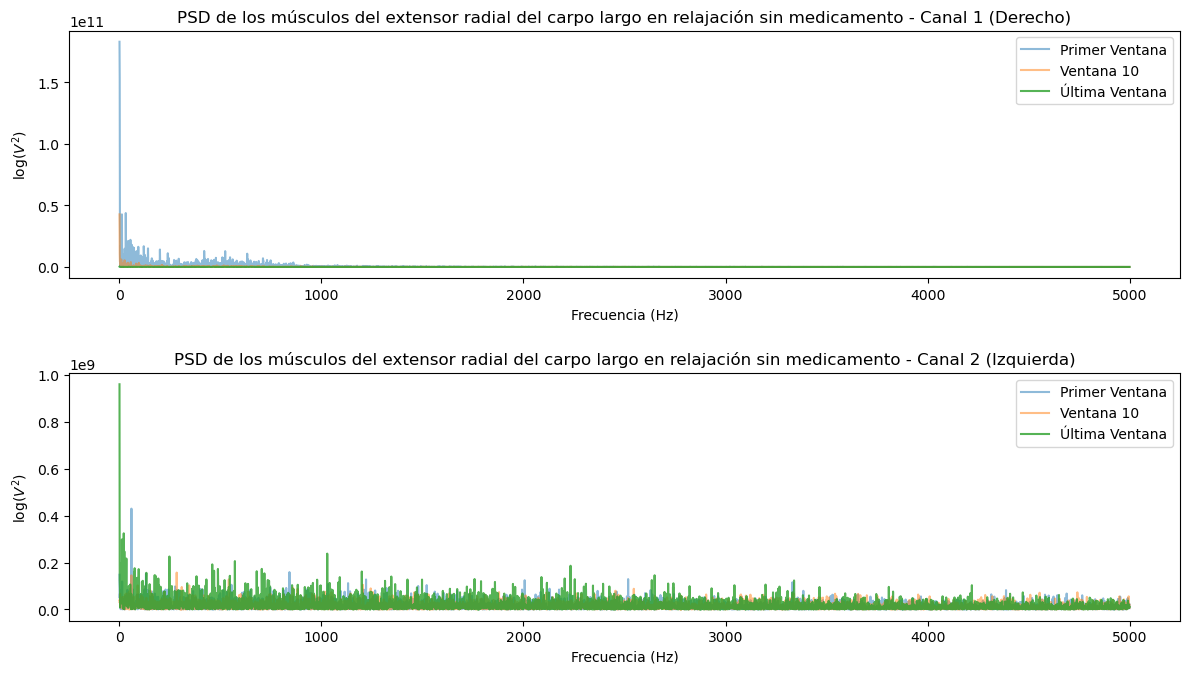

In [9]:
# Ruta del archivo .wav
file_path = '../Parkinson Notebooks/1-Registros-EMG/Sin medicamento/SM_Registro_FlexorLargo_Relajación.wav'

# Definir la función para dividir la señal en ventanas
def windows(data, npoints, step):
    datapts = np.size(data)
    anchorpts = np.arange(0, datapts - npoints, step)
    noverlap = len(anchorpts)
    ovData = [data[anchorpts[i]:anchorpts[i]+npoints] for i in range(noverlap)]
    return ovData

# Definir la función para calcular la PSD
def PSD(data, sampleRate):
    ps = np.abs(np.fft.fft(data))**2
    time_step = 1 / sampleRate
    freqs = np.fft.fftfreq(data.size, time_step)
    idx = np.argsort(freqs)
    good_inds = np.where(freqs[idx] > 0)[0]
    F = freqs[idx][good_inds]
    P = ps[idx][good_inds]
    return F, P

# Abrir el archivo .wav
with wave.open(file_path, 'rb') as wav_file:
    # Obtener los parámetros del archivo .wav
    num_channels = wav_file.getnchannels()
    sampleRate = wav_file.getframerate()
    num_frames = wav_file.getnframes()
    
    # Leer los datos de audio del archivo .wav
    audio_data = wav_file.readframes(num_frames)
    
    # Convertir los datos de audio a un arreglo numpy
    audio_data = np.frombuffer(audio_data, dtype=np.int16)
    
    # Asegurarse de que los valores sean absolutos positivos
    audio_data = np.abs(audio_data)
    
    # Si hay dos canales, separar los datos en dos arreglos
    if num_channels == 2:
        channel1 = audio_data[::2]  # Primer canal
        channel2 = audio_data[1::2]  # Segundo canal
    else:
        # Si no hay dos canales, duplicar los datos para tener dos canales
        channel1 = audio_data
        channel2 = audio_data
    
    # Definir los parámetros para las ventanas
    window_size = sampleRate
    window_step = sampleRate
    
    # Dividir la señal en ventanas para cada canal
    windowedEMG_channel1 = windows(channel1, window_size, window_step)
    windowedEMG_channel2 = windows(channel2, window_size, window_step)
    
    # Crear una figura para graficar las PSD de los dos canales
    fig = plt.figure(figsize=(12, 7))
    
    # Canal 1
    ax = plt.subplot(211)
    ax.plot(PSD(windowedEMG_channel1[0], sampleRate)[0],
            PSD(windowedEMG_channel1[0], sampleRate)[1],
            label='Primer Ventana', alpha=0.5)
    
    ax.plot(PSD(windowedEMG_channel1[10], sampleRate)[0],
            PSD(windowedEMG_channel1[10], sampleRate)[1],
            label='Ventana 10', alpha=0.5)
    
    ax.plot(PSD(windowedEMG_channel1[-1], sampleRate)[0],
            PSD(windowedEMG_channel1[-1], sampleRate)[1],
            label='Última Ventana', alpha=0.8)
    
    #plt.xlim(10, 400)
    plt.legend()
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('log($V^2$)')
    plt.title('PSD de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 1 (Derecho)')
    
    # Canal 2
    ax = plt.subplot(212)
    ax.plot(PSD(windowedEMG_channel2[0], sampleRate)[0],
            PSD(windowedEMG_channel2[0], sampleRate)[1],
            label='Primer Ventana', alpha=0.5)
    
    ax.plot(PSD(windowedEMG_channel2[10], sampleRate)[0],
            PSD(windowedEMG_channel2[10], sampleRate)[1],
            label='Ventana 10', alpha=0.5)
    
    ax.plot(PSD(windowedEMG_channel2[-1], sampleRate)[0],
            PSD(windowedEMG_channel2[-1], sampleRate)[1],
            label='Última Ventana', alpha=0.8)
    
    #plt.xlim(10, 400)
    plt.legend()
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('log($V^2$)')
    plt.title('PSD de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 2 (Izquierda)')
    
    plt.tight_layout()
    plt.show()


<a id='9'></a>
## Frecuencias de potencia media y mediana

El estudio de las frecuencias de potencia media y mediana es útil para obtener información:

> **Caracterización del contenido de frecuencia:** La potencia media y mediana proporcionan una medida cuantitativa del contenido de frecuencia promedio y típico de una señal.

> **Identificación de componentes dominantes:** Estas métricas permiten identificar las bandas de frecuencia con mayor presencia de energía o potencia, lo que puede ayudar a detectar componentes dominantes en una señal.

> **Comparación de señales:** Las frecuencias de potencia media y mediana en diferentes señales, nos permite comparar y contrastar el contenido de frecuencia entre ellas, para analizar similitudes o diferencias en su naturaleza.

> **Detección de anomalías:** Variaciones inusuales en las métricas de potencia media o mediana pueden indicar cambios importantes en el contenido de frecuencia de una señal, lo que puede ser relevante para la detección de anomalías como la actividad espontánea de la Enfermedad de Parkinson.

> **Filtrado de señales:** Estas métricas se pueden utilizar para guiar el diseño de filtros y técnicas de procesamiento de señales que se enfoquen en bandas de frecuencia específicas.

Utilizando la función de la densidad espectral de potencia (PSD), también podemos calcular las frecuencias de potencia media y mediana, que se ha demostrado que cambian con la fatiga muscular.

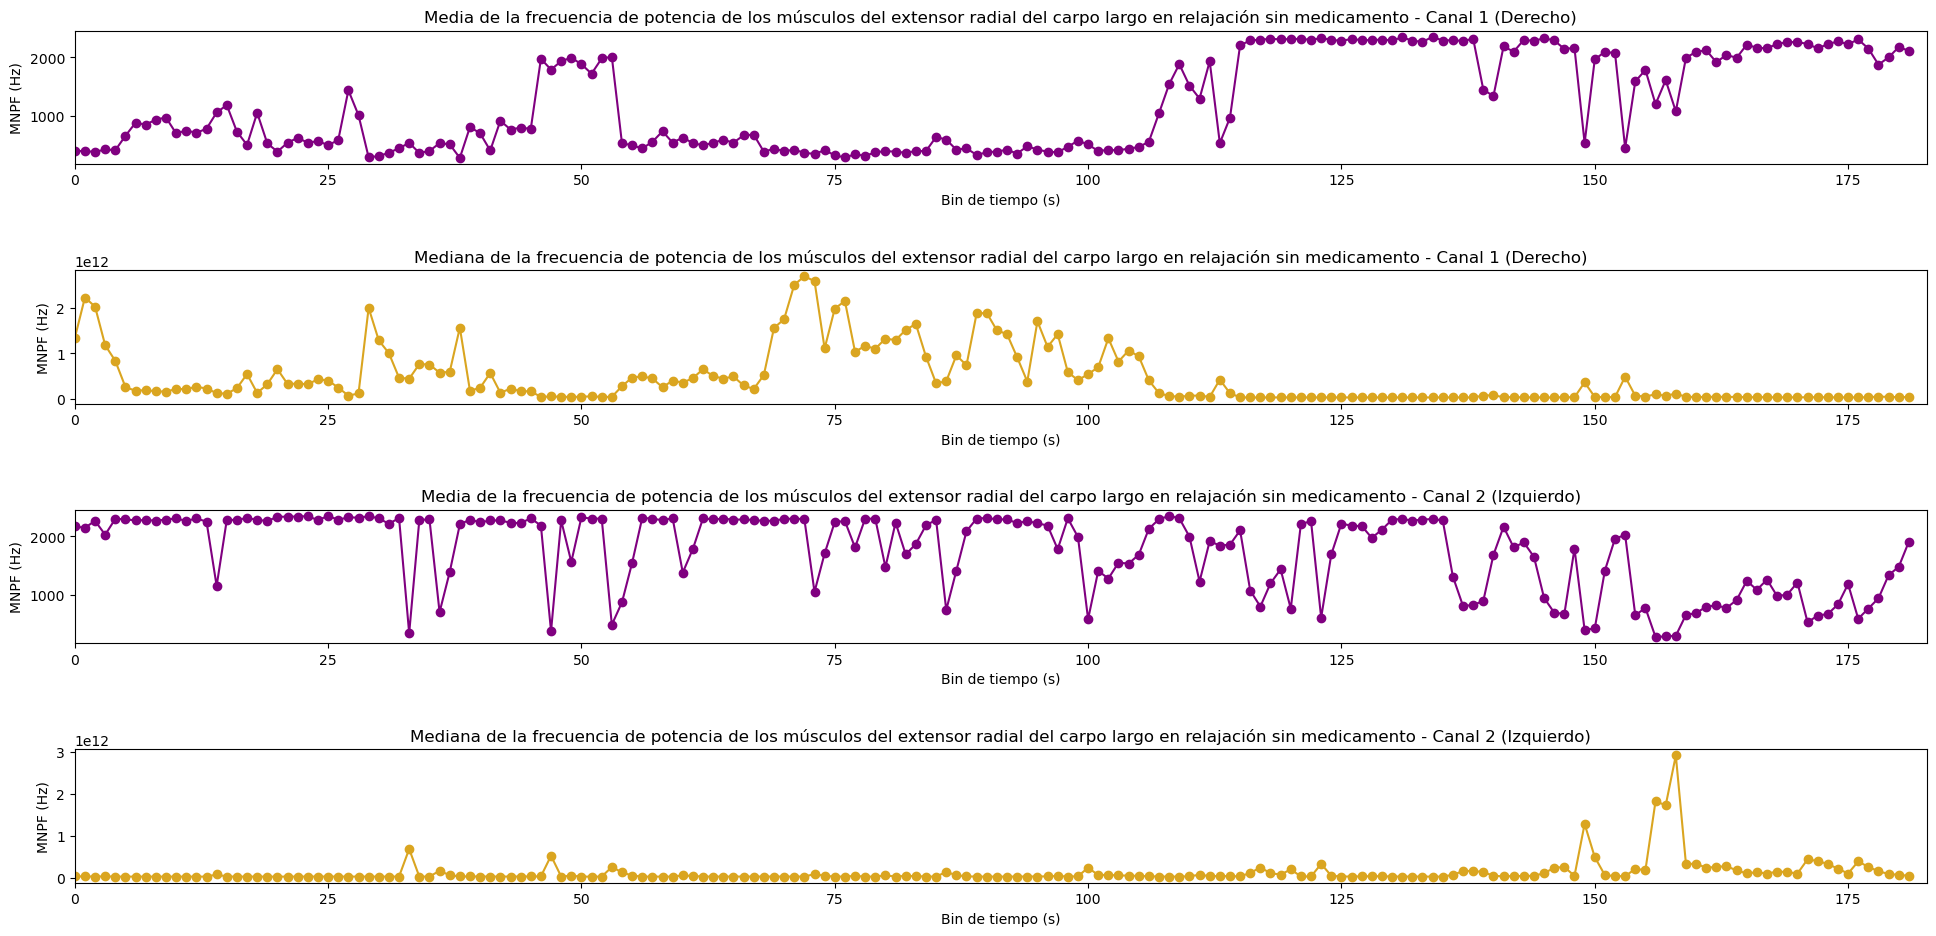

In [10]:
# Definir la función para calcular la media de la frecuencia de potencia
def meanPF(data, sampleRate):
    F, P = PSD(data, sampleRate)
    sumProd = sum([F[i] * P[i] for i in range(len(F))])
    sumPower = sum(P)
    meanPower = sumProd / sumPower
    return round(meanPower, 5)

# Definir la función para calcular la mediana de la frecuencia de potencia
def medianPF(data, sampleRate):
    F, P = PSD(data, sampleRate)
    medianPower = sum(P) / 2
    return round(medianPower, 5)

# Calcular la media de la frecuencia de potencia para cada ventana en cada canal
MNPF_channel1 = list(map(lambda x: meanPF(x, xx['sampleRate']), windowedEMG_channel1))
MNPF_channel2 = list(map(lambda x: meanPF(x, xx['sampleRate']), windowedEMG_channel2))

# Calcular la mediana de la frecuencia de potencia para cada ventana en cada canal
MDPF_channel1 = list(map(lambda x: medianPF(x, xx['sampleRate']), windowedEMG_channel1))
MDPF_channel2 = list(map(lambda x: medianPF(x, xx['sampleRate']), windowedEMG_channel2))
    
# Crear una figura para graficar los resultados
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(20, 10))
    
# Canal 1 - Media de la frecuencia de potencia
ax1.plot(MNPF_channel1, 'o-', color='purple')
ax1.set_title('Media de la frecuencia de potencia de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 1 (Derecho)')
ax1.set_ylabel('MNPF (Hz)')
ax1.set_xlabel('Bin de tiempo (s)')
ax1.set_xlim(0, max(xx['timeEMG']))
    
# Canal 1 - Mediana de la frecuencia de potencia
ax2.plot(MDPF_channel1, 'o-', color='goldenrod')
ax2.set_title('Mediana de la frecuencia de potencia de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 1 (Derecho)')
ax2.set_ylabel('MNPF (Hz)')
ax2.set_xlabel('Bin de tiempo (s)')
ax2.set_xlim(0, max(xx['timeEMG']))
    
# Canal 2 - Media de la frecuencia de potencia
ax3.plot(MNPF_channel2, 'o-', color='purple')
ax3.set_title('Media de la frecuencia de potencia de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 2 (Izquierdo)')
ax3.set_ylabel('MNPF (Hz)')
ax3.set_xlabel('Bin de tiempo (s)')
ax3.set_xlim(0, max(xx['timeEMG']))
    
# Canal 2 - Mediana de la frecuencia de potencia
ax4.plot(MDPF_channel2, 'o-', color='goldenrod')
ax4.set_title('Mediana de la frecuencia de potencia de los músculos del extensor radial del carpo largo en relajación sin medicamento - Canal 2 (Izquierdo)')
ax4.set_ylabel('MNPF (Hz)')
ax4.set_xlabel('Bin de tiempo (s)')
ax4.set_xlim(0, max(xx['timeEMG']))

plt.tight_layout(pad=3.0)
plt.show()

Registros y Notebook elaborado por Alejandro Elliot Flores Oliva, licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Autónoma de México (UNAM), correo: elliotflooli@ciencias.unam.mx